<a href="https://colab.research.google.com/github/budhiacharya/AI-Lesson/blob/main/Assign_14_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 14: Ethical AI Analysis and Explainability

In [1]:
# Install necessary libraries
!pip install fairlearn lime shap imblearn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 51.2 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=3b9e4155d80392672029d393c6a07efb5f6c3cf7e80f0412b47beeba9a2740c7
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


1. Load and Prepare Loan / Credit-Risk Data

In [3]:
# Public German Credit "loan" dataset (credit risk)
url = "https://moodle2425.up.pt/pluginfile.php/173198/mod_label/intro/german_credit_data.csv"

data_raw = pd.read_csv(url)

# Drop the first index-like column (it is just 0,1,2,...)
data = data_raw.iloc[:, 1:].copy()


In [4]:
print("Columns:", data.columns.tolist())
print(data.head())

Columns: ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk']
   Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  Risk  
0         6             radio/TV  good  
1        48             radio/TV   bad  
2        12            education  good  
3        42  furniture/equipment  good  
4        24                  car   bad  


In [5]:
# Handle missing values in important categorical columns
# 'Saving accounts' and 'Checking account' often have NaNs
data['Saving accounts'] = data['Saving accounts'].fillna('unknown')
data['Checking account'] = data['Checking account'].fillna('unknown')

In [9]:
# Target (credit risk: good / bad) -> binary 0/1
# Let's define 1 = bad credit (higher risk), 0 = good credit
y = (data['Risk'] == 'bad').astype(int)

# Features: everything except Risk
X = data.drop(columns=['Risk'])

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

print("\nFeature matrix shape:", X.shape)


Feature matrix shape: (1000, 21)


In [11]:
# Sensitive feature for fairness analysis: Sex
sensitive_feature = data['Sex']

2. Model Training and Evaluation:

In [13]:
# Train-test split with stratification on the target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,
    stratify=y)
# Handle Imbalanced Data and Train Logistic Regression
# Many credit-risk datasets are imbalanced (more "good" than "bad")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print("X_train_res shape:", X_train_res.shape)
print("y_train_res value counts:\n", pd.Series(y_train_res).value_counts())


After SMOTE:
X_train_res shape: (1120, 21)
y_train_res value counts:
 Risk
1    560
0    560
Name: count, dtype: int64


In [14]:
# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000)

In [16]:
# Predictions on test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Model Performance Metrics
print("\n=== Overall Model Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


=== Overall Model Performance ===
Accuracy: 0.705

Confusion Matrix:
 [[110  30]
 [ 29  31]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79       140
           1       0.51      0.52      0.51        60

    accuracy                           0.70       200
   macro avg       0.65      0.65      0.65       200
weighted avg       0.71      0.70      0.71       200



3.  Fairness Analysis with Fairlearn


=== Fairness Metrics by Sex ===
        accuracy  selection_rate  false_positive_rate  true_positive_rate
Sex                                                                      
female  0.688525        0.442623             0.317073               0.700
male    0.712230        0.244604             0.171717               0.425


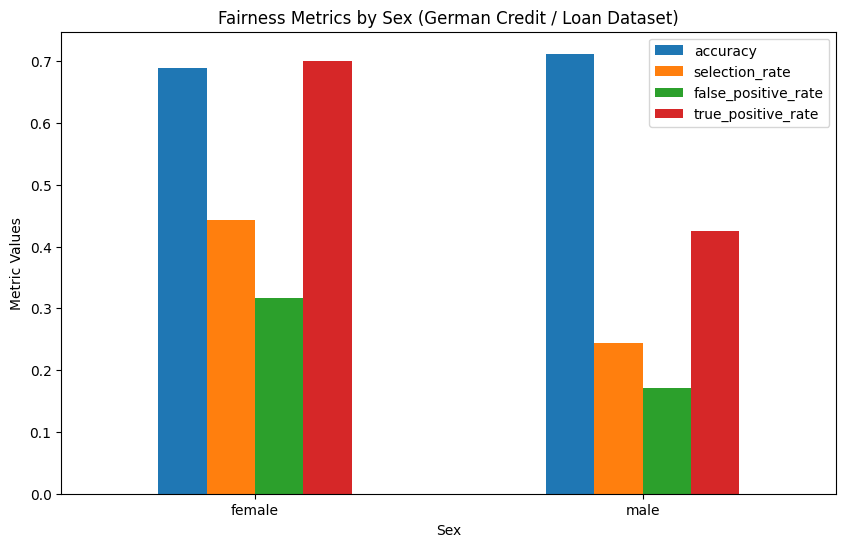

In [18]:
# Align sensitive feature with X_test indices
sensitive_test = sensitive_feature.loc[X_test.index]

metric_frame = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'selection_rate': selection_rate,
        'false_positive_rate': false_positive_rate,
        'true_positive_rate': true_positive_rate
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_test
)

print("\n=== Fairness Metrics by Sex ===")
print(metric_frame.by_group)

# Bar plot of fairness metrics by group
ax = metric_frame.by_group.plot(kind='bar', figsize=(10, 6))
plt.title("Fairness Metrics by Sex (German Credit / Loan Dataset)")
plt.ylabel("Metric Values")
plt.xlabel("Sex")
plt.xticks(rotation=0)
plt.legend(loc='best')
plt.show()

4. Explainability Analysis

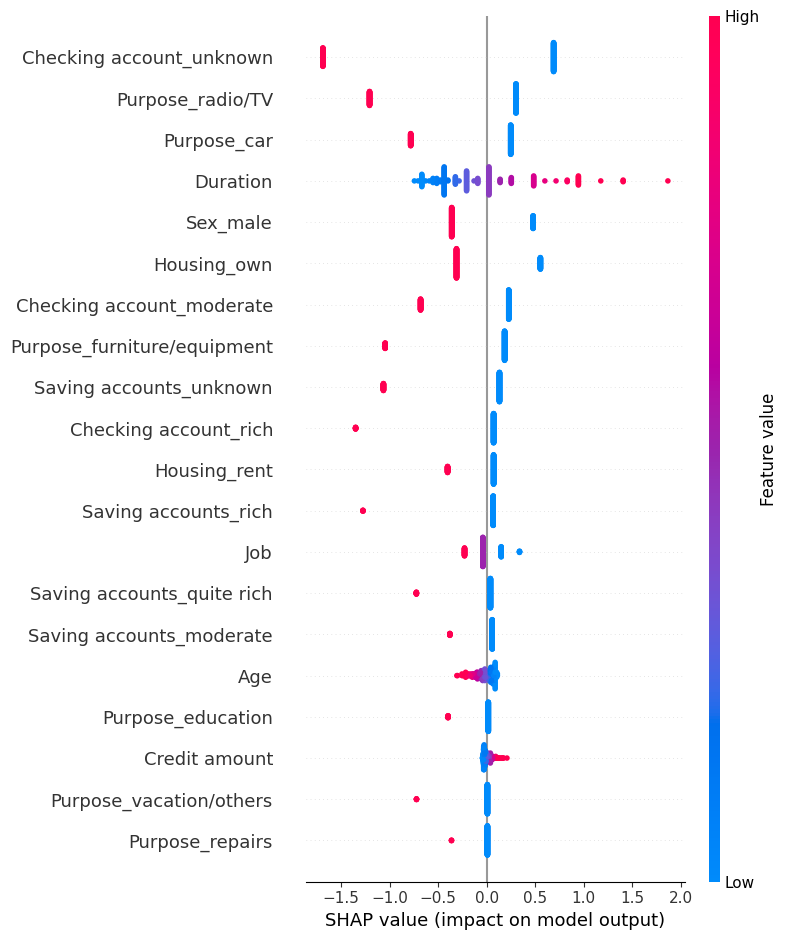


Explaining individual test sample index: 0
True label (1 = bad, 0 = good): 0
Predicted probability of bad credit: 0.2642292912414129


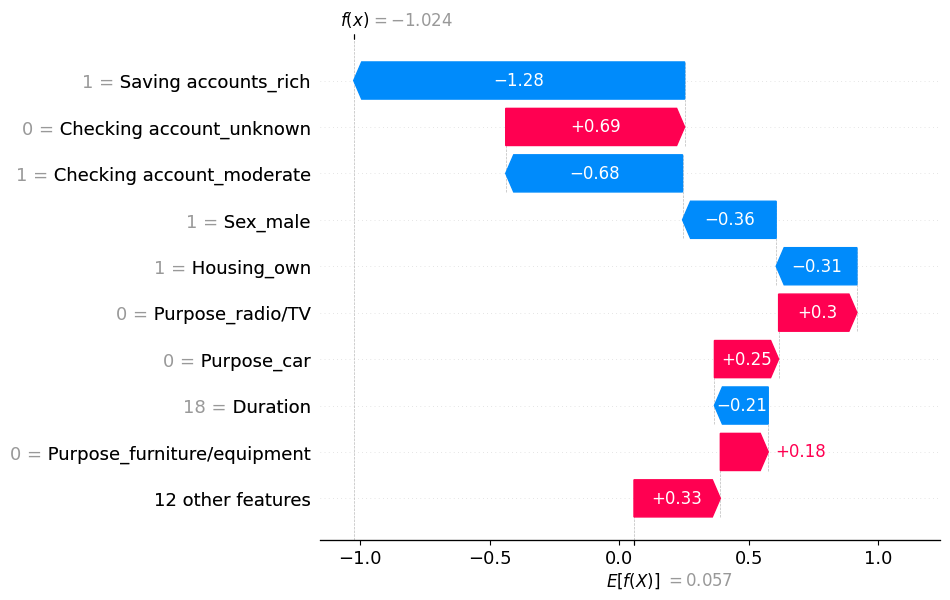

In [23]:
# SHAP analysis
# 5. Explainability Analysis with SHAP
import shap
X_train_shap = pd.DataFrame(X_train_res, columns=X.columns).astype(float)
X_test_shap  = X_test.astype(float)
explainer = shap.Explainer(model, X_train_shap)

# Get SHAP values for the test set
shap_values = explainer(X_test_shap)

# Global explanation: SHAP summary plot
shap.summary_plot(
    shap_values.values,
    X_test_shap,
    feature_names=X.columns  )
# ---- Local explanation: SHAP waterfall plot for one individual ----
idx = 0  # choose the first test example, or any index you like
print("\nExplaining individual test sample index:", idx)
print("True label (1 = bad, 0 = good):", y_test.iloc[idx])
print("Predicted probability of bad credit:", model.predict_proba(X_test_shap.iloc[[idx]])[0, 1])

# shap_values is an Explanation object
shap.plots.waterfall(shap_values[idx])

In [24]:
# Explainability Analysis with LIME

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_res),
    feature_names=X.columns,
    class_names=['Good credit', 'Bad credit'],
    mode='classification')

# Explain the same instance as above using LIME
instance = X_test.iloc[idx].values
lime_exp = lime_explainer.explain_instance(
    data_row=instance,
    predict_fn=model.predict_proba,
    num_features=10)
lime_exp.show_in_notebook(show_table=True)
